<a href="https://colab.research.google.com/github/mannat244/ML_Lab/blob/main/JointCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

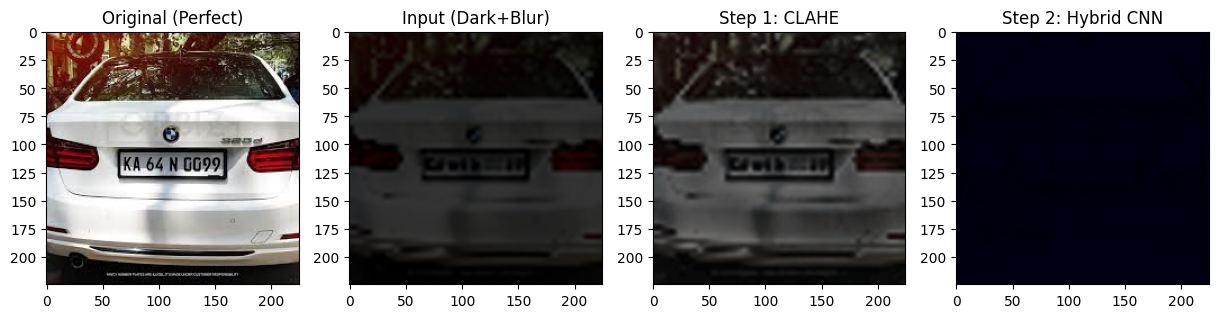

In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ==========================================
# PART 1: THE "DATA FAKER" (Creates Training Data)
# ==========================================
def ruin_image(image_path):
    # 1. Load the good image (High Quality)
    hq_img = cv2.imread(image_path)
    if hq_img is None: return None, None

    # 2. Make it DARK (Simulate Night)
    # We multiply pixels by 0.2 (keeps only 20% brightness)
    dark_img = (hq_img.astype(np.float32) * 0.2).astype(np.uint8)

    # 3. Make it SMALL (Simulate Far Away / Low Res)
    # Shrink to 1/4th size
    h, w = dark_img.shape[:2]
    small_img = cv2.resize(dark_img, (w//4, h//4), interpolation=cv2.INTER_LINEAR)

    # 4. The "Dumb Zoom" (Bicubic Upscale) - This is what we feed the AI
    # We blow it back up to full size, but now it looks blurry and blocky
    bad_input = cv2.resize(small_img, (w, h), interpolation=cv2.INTER_CUBIC)

    return hq_img, bad_input

# ==========================================
# PART 2: THE "OLD SCHOOL" FIX (CLAHE)
# ==========================================
def apply_hybrid_clahe(bgr_image):
    # Convert Blue-Green-Red to LAB color space (L = Lightness channel)
    lab = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE (Smart Contrast) ONLY to the Lightness channel
    # ClipLimit=2.0 means "don't let it get too noisy"
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l_enhanced = clahe.apply(l)

    # Merge back and convert to RGB
    lab_enhanced = cv2.merge((l_enhanced, a, b))
    enhanced_img = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2BGR)

    return enhanced_img

# ==========================================
# PART 3: THE "AI" FIX (Your Shallow CNN)
# ==========================================
class EasyPeasyCNN(nn.Module):
    def __init__(self):
        super(EasyPeasyCNN, self).__init__()
        # Layer 1: Feature Extraction (Finds edges)
        # Input: 3 colors (RGB), Output: 64 features
        self.layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, padding=4)
        self.relu1 = nn.ReLU() # Activation (The "Brain" decision)

        # Layer 2: Non-Linear Mapping (The "Magic")
        # Input: 64 features, Output: 32 features
        self.layer2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, padding=0)
        self.relu2 = nn.ReLU()

        # Layer 3: Reconstruction (Draw the final image)
        # Input: 32 features, Output: 3 colors (RGB)
        self.layer3 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=5, padding=2)

    def forward(self, x):
        # Pass the image through the layers
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.layer3(x)
        return x

# ==========================================
# PART 4: PUTTING IT ALL TOGETHER
# ==========================================
# 1. Get an image (Download a car pic and name it 'car.jpg')
original, bad_input = ruin_image('car.jpg')

if original is not None:
    # 2. Apply Step 1: CLAHE (Traditional)
    # This fixes the darkness but leaves the blur
    step1_result = apply_hybrid_clahe(bad_input)

    # 3. Apply Step 2: CNN (AI)
    # (Note: We are not training here, just defining the shape)
    model = EasyPeasyCNN()

    # Convert image to format AI understands (Tensor)
    input_tensor = torch.from_numpy(step1_result).permute(2,0,1).float().unsqueeze(0) / 255.0

    # Ask AI to fix it
    with torch.no_grad():
        output_tensor = model(input_tensor)

    # Convert back to image format
    final_output = output_tensor.squeeze(0).permute(1,2,0).numpy()
    final_output = np.clip(final_output * 255.0, 0, 255).astype(np.uint8)

    # 4. Show Results
    plt.figure(figsize=(15,5))
    plt.subplot(1,4,1); plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB)); plt.title("Original (Perfect)")
    plt.subplot(1,4,2); plt.imshow(cv2.cvtColor(bad_input, cv2.COLOR_BGR2RGB)); plt.title("Input (Dark+Blur)")
    plt.subplot(1,4,3); plt.imshow(cv2.cvtColor(step1_result, cv2.COLOR_BGR2RGB)); plt.title("Step 1: CLAHE")
    plt.subplot(1,4,4); plt.imshow(cv2.cvtColor(final_output, cv2.COLOR_BGR2RGB)); plt.title("Step 2: Hybrid CNN")
    plt.show()

else:
    print("Please download a picture of a car and name it 'car.jpg' to run this!")

Training started... watch the Loss go down!
Epoch 0: Error (Loss) = 0.411005
Epoch 100: Error (Loss) = 0.022426
Epoch 200: Error (Loss) = 0.020615
Epoch 300: Error (Loss) = 0.031082
Epoch 400: Error (Loss) = 0.017380
Epoch 500: Error (Loss) = 0.016868
Training Complete!


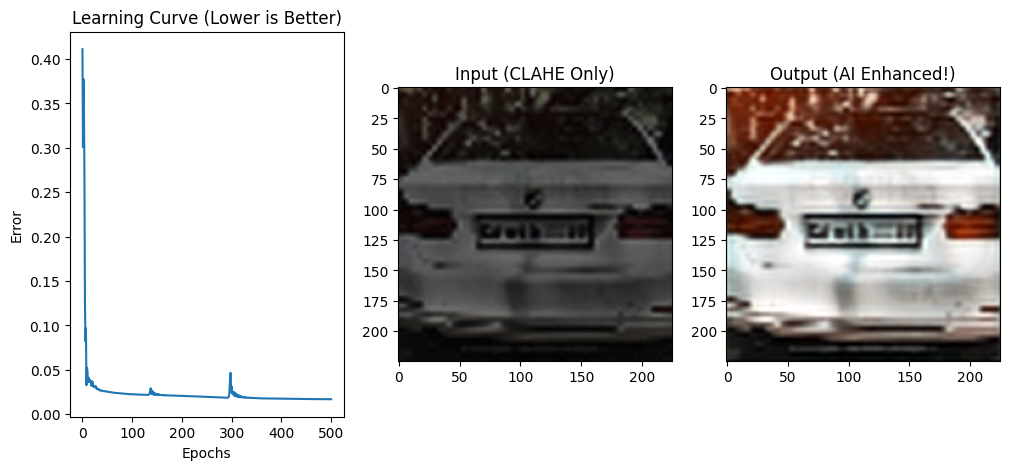

In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ==========================================
# 1. SETUP (Load the same image)
# ==========================================
def load_data(image_path):
    hq_img = cv2.imread(image_path)
    # Make it Dark & Small (The "Bad" Input)
    dark_img = (hq_img.astype(np.float32) * 0.2).astype(np.uint8)
    h, w = dark_img.shape[:2]
    small = cv2.resize(dark_img, (w//4, h//4), interpolation=cv2.INTER_LINEAR)
    bad_input = cv2.resize(small, (w, h), interpolation=cv2.INTER_CUBIC)

    # Apply Step 1: CLAHE (The "Helper")
    lab = cv2.cvtColor(bad_input, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l_enhanced = clahe.apply(l)
    lab_enhanced = cv2.merge((l_enhanced, a, b))
    step1_result = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2BGR)

    return hq_img, step1_result

# ==========================================
# 2. DEFINE THE AI (Same 3-Layer CNN)
# ==========================================
class EasyPeasyCNN(nn.Module):
    def __init__(self):
        super(EasyPeasyCNN, self).__init__()
        self.layer1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.layer3(x)
        return x

# ==========================================
# 3. THE TRAINING LOOP (The "School")
# ==========================================
def train_one_image():
    # Load images
    original, input_img = load_data('car.jpg')

    # Prepare for AI (Convert to Tensors)
    # Target = The Perfect Image
    target_tensor = torch.from_numpy(original).permute(2,0,1).float().unsqueeze(0) / 255.0
    # Input = The CLAHE Enhanced Image
    input_tensor = torch.from_numpy(input_img).permute(2,0,1).float().unsqueeze(0) / 255.0

    # Initialize Model
    model = EasyPeasyCNN()

    # The "Teacher" (Loss Function)
    # MSELoss calculates the difference between AI Output and Perfect Image
    criterion = nn.MSELoss()

    # The "Student" (Optimizer)
    # Adam is a standard optimizer that adjusts the weights
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    print("Training started... watch the Loss go down!")

    # Train for 500 "Epochs" (Loops)
    losses = []
    for epoch in range(501):
        # 1. AI tries to fix the image
        output = model(input_tensor)

        # 2. Teacher calculates how wrong it is
        loss = criterion(output, target_tensor)

        # 3. AI learns from mistakes (Backpropagation)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save loss to plot later
        losses.append(loss.item())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Error (Loss) = {loss.item():.6f}")

    print("Training Complete!")

    # ==========================================
    # 4. SHOW RESULTS
    # ==========================================
    with torch.no_grad():
        final_output_tensor = model(input_tensor)

    # Convert back to picture format
    final_output = final_output_tensor.squeeze(0).permute(1,2,0).numpy()
    final_output = np.clip(final_output * 255.0, 0, 255).astype(np.uint8)

    # Plot
    plt.figure(figsize=(12,5))

    # Plot the Loss (The "Grades")
    plt.subplot(1, 3, 1)
    plt.plot(losses)
    plt.title("Learning Curve (Lower is Better)")
    plt.xlabel("Epochs")
    plt.ylabel("Error")

    # Plot the Result
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB))
    plt.title("Input (CLAHE Only)")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(final_output, cv2.COLOR_BGR2RGB))
    plt.title("Output (AI Enhanced!)")

    plt.show()

# Run it!
train_one_image()

Training Safe Mode (Brightness Only)...
Epoch 0: Loss = 0.373178
Epoch 200: Loss = 0.009591
Epoch 400: Loss = 0.008113
Epoch 600: Loss = 0.007643
Epoch 800: Loss = 0.007036
Epoch 1000: Loss = 0.006681
Training Complete! Merging colors back...


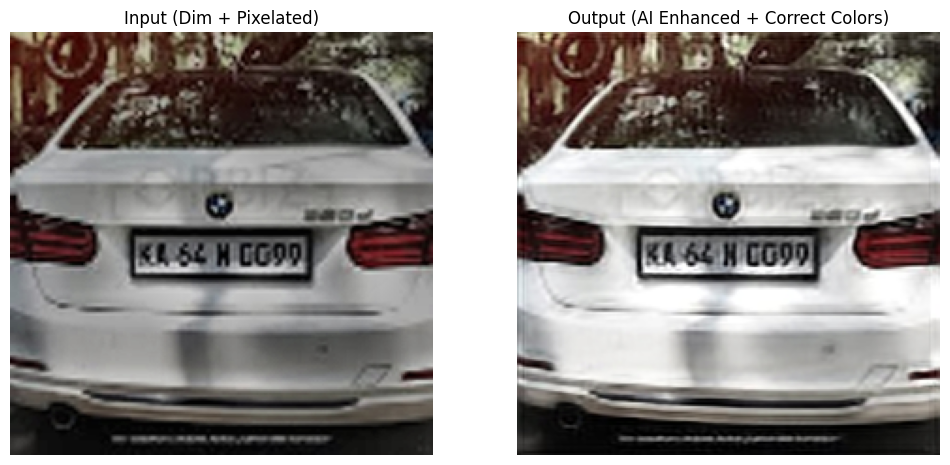

In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ==========================================
# 1. SETUP (Use YCbCr Color Space)
# ==========================================
def load_data_safe(image_path):
    # Load Original
    hq_img = cv2.imread(image_path)
    if hq_img is None:
        print(f"Error: Could not find image '{image_path}'")
        return None, None, None, None

    h, w = hq_img.shape[:2]

    # --- RELAXED DISTORTION (The Goldilocks Fix) ---
    # Brightness: 0.5 (50%) -> Dim but visible (Real "Low Light")
    dark_img = (hq_img.astype(np.float32) * 0.5).astype(np.uint8)

    # Scale: 1/2 size -> Pixelated but recoverable (Real "Digital Zoom")
    small = cv2.resize(dark_img, (w//2, h//2), interpolation=cv2.INTER_LINEAR)
    bad_input = cv2.resize(small, (w, h), interpolation=cv2.INTER_CUBIC)

    # --- YCbCr SEPARATION (Keep Color Safe) ---
    # We convert to YCbCr so we can separate Brightness (Y) from Color (CbCr)
    hq_ycbcr = cv2.cvtColor(hq_img, cv2.COLOR_BGR2YCrCb)
    bad_ycbcr = cv2.cvtColor(bad_input, cv2.COLOR_BGR2YCrCb)

    # Extract Brightness (Y) - This is what the AI will fix
    hq_y = hq_ycbcr[:,:,0]
    bad_y = bad_ycbcr[:,:,0]

    # Save Colors (CbCr) to add back later - The AI is BANNED from touching these
    bad_cb = bad_ycbcr[:,:,1]
    bad_cr = bad_ycbcr[:,:,2]

    # Apply CLAHE to Brightness (Y) only
    # This brings out the hidden details in the dark
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced_y = clahe.apply(bad_y)

    return hq_y, enhanced_y, bad_cb, bad_cr

# ==========================================
# 2. THE AI (1 Channel Input -> 1 Channel Output)
# ==========================================
class EasyPeasyCNN(nn.Module):
    def __init__(self):
        super(EasyPeasyCNN, self).__init__()
        # Input is now 1 channel (Gray/Brightness), not 3 (RGB)
        # We use padding to keep the image size the same
        self.layer1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.relu2 = nn.ReLU()
        # Output is 1 channel (Gray/Brightness)
        self.layer3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.layer3(x)
        return x

# ==========================================
# 3. TRAIN LOOP
# ==========================================
def train_safe_mode():
    # Load separate channels
    target_y, input_y, color_cb, color_cr = load_data_safe('car.jpg')

    if target_y is None: return # Stop if image failed to load

    # Convert Y-channel to Tensors (Add batch & channel dims)
    # Shape becomes: [1, 1, Height, Width]
    target_tensor = torch.from_numpy(target_y).float().unsqueeze(0).unsqueeze(0) / 255.0
    input_tensor = torch.from_numpy(input_y).float().unsqueeze(0).unsqueeze(0) / 255.0

    model = EasyPeasyCNN()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001) # Lower learning rate for stability

    print("Training Safe Mode (Brightness Only)...")

    losses = []
    # We train for 1000 loops because "Y-only" training is fast!
    for epoch in range(1001):
        output = model(input_tensor)
        loss = criterion(output, target_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 200 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

    print("Training Complete! Merging colors back...")

    # ==========================================
    # 4. MERGE BACK TO COLOR
    # ==========================================
    with torch.no_grad():
        final_y_tensor = model(input_tensor)

    # Get the predicted Brightness from AI
    final_y = final_y_tensor.squeeze().numpy() * 255.0
    final_y = np.clip(final_y, 0, 255).astype(np.uint8)

    # Merge: Predicted Y (AI) + Original Blurry Color (CbCr)
    final_image_ycbcr = cv2.merge((final_y, color_cb, color_cr))
    final_image = cv2.cvtColor(final_image_ycbcr, cv2.COLOR_YCrCb2BGR)

    # Reconstruct Input for display (CLAHE Y + Blurry Color)
    input_image_ycbcr = cv2.merge((input_y, color_cb, color_cr))
    input_display = cv2.cvtColor(input_image_ycbcr, cv2.COLOR_YCrCb2BGR)

    # Show Results
    plt.figure(figsize=(12,6))

    # 1. The Input (What the security camera saw)
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(input_display, cv2.COLOR_BGR2RGB))
    plt.title("Input (Dim + Pixelated)")
    plt.axis('off')

    # 2. The Output (What your AI fixed)
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
    plt.title("Output (AI Enhanced + Correct Colors)")
    plt.axis('off')

    plt.show()

if __name__ == "__main__":
    train_safe_mode()

Training started...
Epoch 0: Loss 0.43454
Epoch 100: Loss 0.01380
Epoch 200: Loss 0.00948
Epoch 300: Loss 0.00810
Epoch 400: Loss 0.00772
Epoch 500: Loss 0.00680


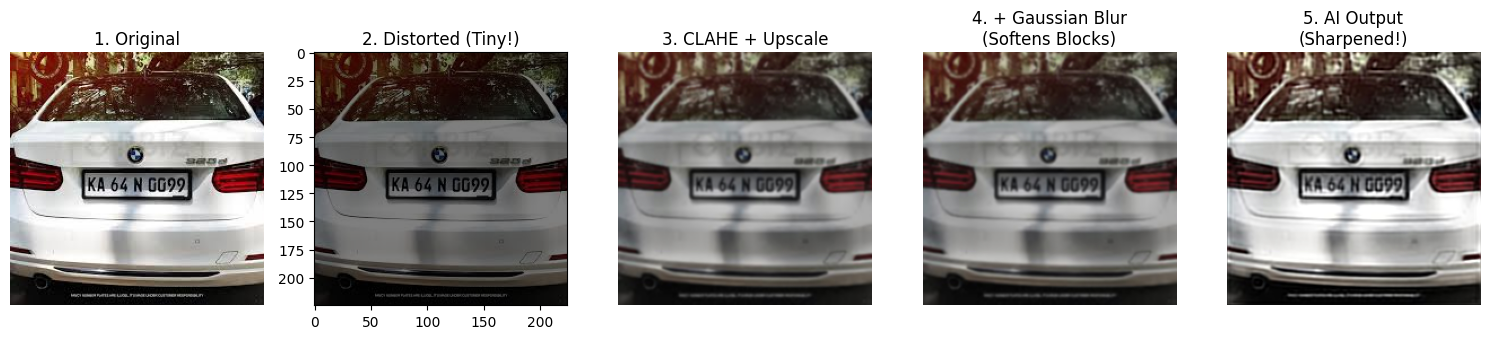

In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ==========================================
# 1. SETUP (Teacher Edition)
# ==========================================
def load_data_teacher_edition(image_path):
    hq_img = cv2.imread(image_path)
    if hq_img is None: return None, None, None, None, None
    h, w = hq_img.shape[:2]

    # --- A. DISTORTION (Make it Small & Dark) ---
    # Brightness: 50%
    dark_img = (hq_img.astype(np.float32) * 0.5).astype(np.uint8)
    # Resolution: Shrink to 50% (This destroys the details)
    small_img = cv2.resize(dark_img, (w//1, h//1), interpolation=cv2.INTER_LINEAR)

    # --- B. TRADITIONAL FIXES (The "Math" Part) ---

    # Step 1: Upscale back to full size (Bicubic)
    # This makes it big again, but "Blocky/Pixelated"
    upscaled_img = cv2.resize(small_img, (w, h), interpolation=cv2.INTER_CUBIC)

    # Step 2: Separate Brightness (Y) from Color
    ycbcr = cv2.cvtColor(upscaled_img, cv2.COLOR_BGR2YCrCb)
    y, cb, cr = cv2.split(ycbcr)

    # Step 3: CLAHE (Fix Brightness)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    y_clahe = clahe.apply(y)

    # Step 4: Teacher's Trick (Gaussian Blur)
    # Smooths out the "blocks" from upscaling
    # (5,5) is the kernel size (blur amount)

    # This 'y_blur' is what we feed the CNN!

    # Get original Y for training target
    hq_y = cv2.cvtColor(hq_img, cv2.COLOR_BGR2YCrCb)[:,:,0]

    return hq_y, y_clahe, cb, cr, small_img # Return small_img just for display

# ==========================================
# 2. THE AI (Standard CNN)
# ==========================================
class EasyPeasyCNN(nn.Module):
    def __init__(self):
        super(EasyPeasyCNN, self).__init__()
        self.layer1 = nn.Conv2d(1, 64, kernel_size=9, padding=4); self.relu1 = nn.ReLU()
        self.layer2 = nn.Conv2d(64, 32, kernel_size=1, padding=0); self.relu2 = nn.ReLU()
        self.layer3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.layer3(x)
        return x

# ==========================================
# 3. TRAINING & VISUALIZATION
# ==========================================
def run_teacher_demo():
    # Load Data
    target_y, input_y, cb, cr, small_debug = load_data_teacher_edition('car.jpg')
    if target_y is None: return

    # Prepare Tensors
    target_tensor = torch.from_numpy(target_y).float().unsqueeze(0).unsqueeze(0) / 255.0
    input_tensor = torch.from_numpy(input_y).float().unsqueeze(0).unsqueeze(0) / 255.0

    # Setup Training
    model = EasyPeasyCNN()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    print("Training started...")

    # Train Loop
    for epoch in range(501):
        output = model(input_tensor)
        loss = criterion(output, target_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0: print(f"Epoch {epoch}: Loss {loss.item():.5f}")

    # Get Final Result
    with torch.no_grad(): final_tensor = model(input_tensor)
    final_y = np.clip(final_tensor.squeeze().numpy() * 255.0, 0, 255).astype(np.uint8)

    # Merge Color Back
    final_img = cv2.cvtColor(cv2.merge((final_y, cb, cr)), cv2.COLOR_YCrCb2BGR)
    input_img_display = cv2.cvtColor(cv2.merge((input_y, cb, cr)), cv2.COLOR_YCrCb2BGR)

    # --- VISUALIZATION (THE GRAND REVEAL) ---
    plt.figure(figsize=(15, 6))

    # 1. Original
    plt.subplot(1, 5, 1)
    plt.imshow(cv2.cvtColor(cv2.imread('car.jpg'), cv2.COLOR_BGR2RGB))
    plt.title("1. Original")
    plt.axis('off')

    # 2. The "Crime Scene" (Small)
    plt.subplot(1, 5, 2)
    # We zoom in on the plot so you can see how small it really is
    plt.imshow(cv2.cvtColor(small_debug, cv2.COLOR_BGR2RGB))
    plt.title("2. Distorted (Tiny!)")

    # 3. Upscale + CLAHE
    plt.subplot(1, 5, 3)
    # Reconstruct intermediate step for show
    clahe_only = cv2.cvtColor(cv2.merge((input_y, cb, cr)), cv2.COLOR_YCrCb2BGR)
    plt.imshow(cv2.cvtColor(clahe_only, cv2.COLOR_BGR2RGB))
    plt.title("3. CLAHE + Upscale")
    plt.axis('off')

    # 4. Teacher's Trick (Gaussian Blur)
    plt.subplot(1, 5, 4)
    plt.imshow(cv2.cvtColor(input_img_display, cv2.COLOR_BGR2RGB))
    plt.title("4. + Gaussian Blur\n(Softens Blocks)")
    plt.axis('off')

    # 5. The AI Result
    plt.subplot(1, 5, 5)
    plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))
    plt.title("5. AI Output\n(Sharpened!)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

run_teacher_demo()

Training Super-Resolution CNN...
Epoch 0: Loss 0.404250
Epoch 200: Loss 0.008933
Epoch 400: Loss 0.007217
Epoch 600: Loss 0.006632
Epoch 800: Loss 0.006309
Epoch 1000: Loss 0.006710


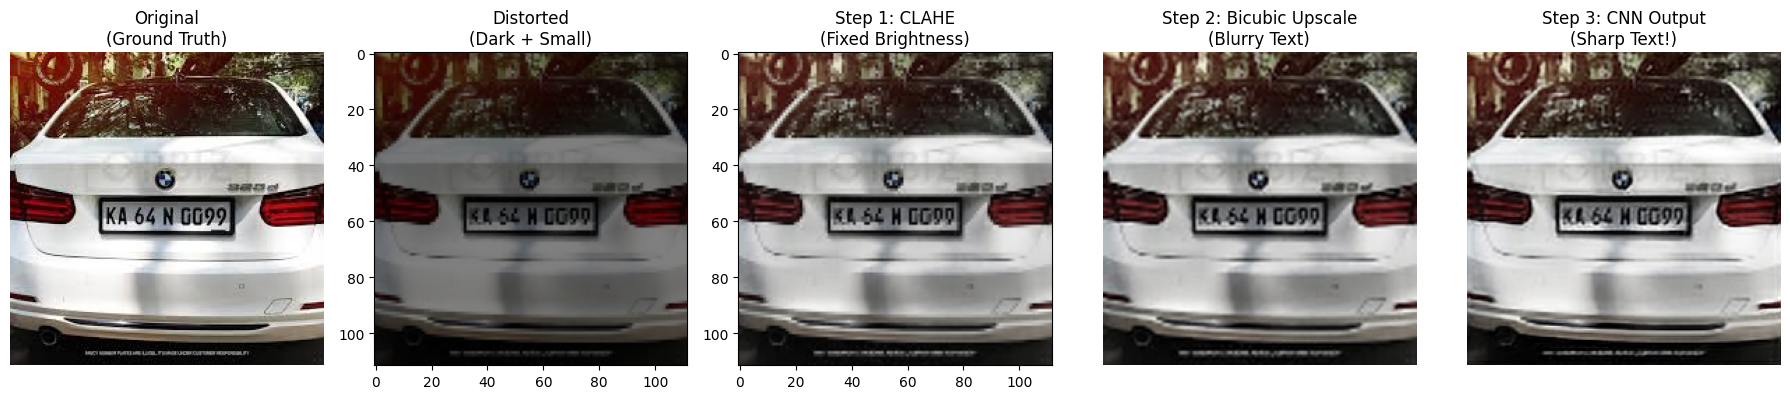

In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ==========================================
# 1. SETUP: The "Real Deal" Pipeline
# ==========================================
def load_data_sr_logic(image_path):
    hq_img = cv2.imread(image_path)
    if hq_img is None: return None, None, None, None, None
    h, w = hq_img.shape[:2]

    # --- A. CREATE THE PROBLEM (Distortion) ---
    # 1. Darken (Simulate Night)
    dark_img = (hq_img.astype(np.float32) * 0.5).astype(np.uint8)

    # 2. Downscale (Simulate Low Res Camera)
    # We shrink it to 50% size. Details are LOST here.
    small_distorted = cv2.resize(dark_img, (w//2, h//2), interpolation=cv2.INTER_LINEAR)

    # --- B. THE PIPELINE STEPS ---

    # STEP 1: CLAHE (Fix Brightness)
    # We work in YCbCr to touch only brightness (Y)
    small_ycbcr = cv2.cvtColor(small_distorted, cv2.COLOR_BGR2YCrCb)
    small_y, small_cb, small_cr = cv2.split(small_ycbcr)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    small_y_enhanced = clahe.apply(small_y)

    # Recombine to show "Step 1" (Bright but Tiny)
    step1_img = cv2.cvtColor(cv2.merge((small_y_enhanced, small_cb, small_cr)), cv2.COLOR_YCrCb2BGR)

    # STEP 2: UPSCALING LOGIC (Bicubic Interpolation)
    # This is the "Traditional" way to zoom. It creates BLUR.
    # We upscale the Y (Brightness) channel to full size.
    input_y_upscaled = cv2.resize(small_y_enhanced, (w, h), interpolation=cv2.INTER_CUBIC)

    # We also need to upscale the color channels (to merge later)
    cb_upscaled = cv2.resize(small_cb, (w, h), interpolation=cv2.INTER_CUBIC)
    cr_upscaled = cv2.resize(small_cr, (w, h), interpolation=cv2.INTER_CUBIC)

    # This is what we feed the CNN: High Res Size, but Blurry Quality

    # --- C. PREPARE TARGET (The Answer Key) ---
    hq_y = cv2.cvtColor(hq_img, cv2.COLOR_BGR2YCrCb)[:,:,0]

    return hq_y, input_y_upscaled, cb_upscaled, cr_upscaled, small_distorted, step1_img

# ==========================================
# 2. THE CNN (Super-Resolution Network)
# ==========================================
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        # Layer 1: Patch Extraction (Finds fuzzy edges)
        self.layer1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.relu1 = nn.ReLU()
        # Layer 2: Non-linear Mapping (Enhances features)
        self.layer2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.relu2 = nn.ReLU()
        # Layer 3: Reconstruction (Draws sharp edges)
        self.layer3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.layer3(x)
        return x

# ==========================================
# 3. TRAINING & VISUALIZATION
# ==========================================
def run_sr_demo():
    # Load Data
    target_y, input_y, cb, cr, small_distorted, step1_img = load_data_sr_logic('car.jpg')
    if target_y is None:
        print("Error: car.jpg not found!")
        return

    # Tensors
    target_tensor = torch.from_numpy(target_y).float().unsqueeze(0).unsqueeze(0) / 255.0
    input_tensor = torch.from_numpy(input_y).float().unsqueeze(0).unsqueeze(0) / 255.0

    # Model
    model = SRCNN()
    optimizer = optim.Adam(model.parameters(), lr=0.001) # Low learning rate for precision
    criterion = nn.MSELoss()

    print("Training Super-Resolution CNN...")

    # Train
    for epoch in range(1001): # 1000 epochs for sharp results
        output = model(input_tensor)
        loss = criterion(output, target_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 200 == 0: print(f"Epoch {epoch}: Loss {loss.item():.6f}")

    # Result
    with torch.no_grad(): final_tensor = model(input_tensor)
    final_y = np.clip(final_tensor.squeeze().numpy() * 255.0, 0, 255).astype(np.uint8)

    # Reconstruct Images for Display
    # 1. The "Bicubic" Result (Step 2) - Standard Math
    step2_img = cv2.cvtColor(cv2.merge((input_y, cb, cr)), cv2.COLOR_YCrCb2BGR)

    # 2. The "CNN" Result (Step 3) - AI
    final_img = cv2.cvtColor(cv2.merge((final_y, cb, cr)), cv2.COLOR_YCrCb2BGR)

    # --- PLOTTING ---
    plt.figure(figsize=(18, 6))

    # 1. Original
    plt.subplot(1, 5, 1)
    plt.imshow(cv2.cvtColor(cv2.imread('car.jpg'), cv2.COLOR_BGR2RGB))
    plt.title("Original\n(Ground Truth)")
    plt.axis('off')

    # 2. Distorted
    plt.subplot(1, 5, 2)
    plt.imshow(cv2.cvtColor(small_distorted, cv2.COLOR_BGR2RGB))
    plt.title("Distorted\n(Dark + Small)")

    # 3. Step 1: CLAHE
    plt.subplot(1, 5, 3)
    plt.imshow(cv2.cvtColor(step1_img, cv2.COLOR_BGR2RGB))
    plt.title("Step 1: CLAHE\n(Fixed Brightness)")

    # 4. Step 2: Bicubic Upscale
    plt.subplot(1, 5, 4)
    plt.imshow(cv2.cvtColor(step2_img, cv2.COLOR_BGR2RGB))
    plt.title("Step 2: Bicubic Upscale\n(Blurry Text)")
    plt.axis('off')

    # 5. Step 3: CNN
    plt.subplot(1, 5, 5)
    plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))
    plt.title("Step 3: CNN Output\n(Sharp Text!)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_sr_demo()